### Applying everest 2.0 PLD manually to detrend K2 light curves 
19 April 2019

See [EVEREST documentation](https://rodluger.github.io/everest/detrender.html#everest.detrender.rPLD)

In [129]:
from analysis import *
import everest 

import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

In [167]:
# load in ed shaya objects
shaya = pd.read_csv('./object_keys/c8_shaya.csv')
test_epic = shaya['EPIC ID'][100]

Test out on objects that aren't on EVEREST MAST database with both rPLD (regular PLD) and nPLD(PLD with neighboring star calculations):

In [131]:
%%time
rpld = everest.detrender.rPLD(test_epic, season=8)

CPU times: user 258 ms, sys: 4.63 ms, total: 263 ms
Wall time: 266 ms


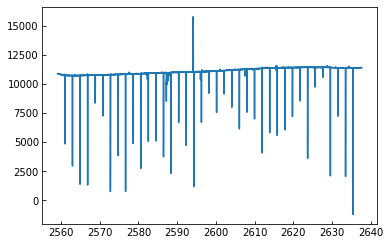

In [145]:
plt.plot(rpld.time, rpld.flux)

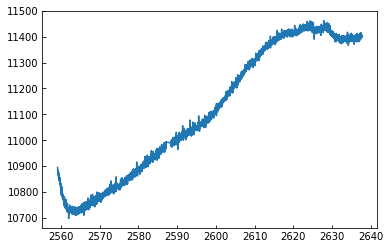

In [161]:
# clean it up by removing cadences marked in .badmask and .nanmask
rpld_mask = (np.isin(np.arange(3852+1), np.concatenate([rpld.nanmask, rpld.badmask, rpld.mask])))
plt.plot(rpld.time[~rpld_mask], rpld.flux[~rpld_mask])

In [133]:
%%time
npld = everest.detrender.nPLD(test_epic, season=8)

CPU times: user 251 ms, sys: 46.6 ms, total: 298 ms
Wall time: 255 ms


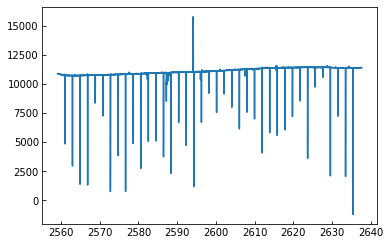

In [146]:
plt.plot(npld.time, rpld.flux)

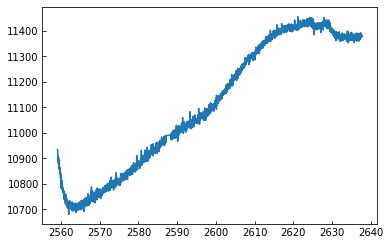

In [162]:
# clean it up by removing cadences marked in .badmask and .nanmask
npld_mask = (np.isin(np.arange(3852+1), np.concatenate([npld.nanmask, npld.badmask, npld.mask])))
plt.plot(npld.time[~npld_mask], npld.flux[~npld_mask])

The detrender takes a long time to run if it's being used on an object for the first time.

---
### Remove first 5 days and subtract linear fit

---
### Look at PSDs (before and after)

In [165]:
# get the raw light curves
tpf = lk.search_targetpixelfile(test_epic, campaign=8).download() # define tpf

# get raw lightcurve
lc = tpf.to_lightcurve(aperture_mask='all')
_, spurious_cadences = lc.flatten().remove_outliers(return_mask=True) # remove spurious cadences
lc_raw = lc[~spurious_cadences]

258 cadences will be ignored (bitmask=1130799)


Text(0.5, 0.98, 'EPIC 220165960, K2 Campaign 8')

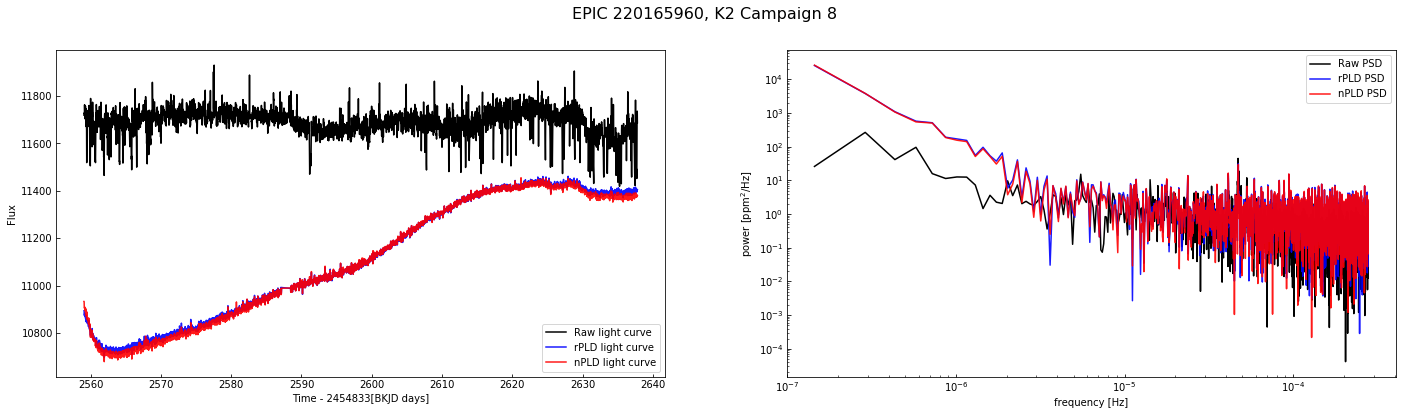

In [166]:
# plot them
fig, ax = plt.subplots(1,2, figsize=(24,6))
plot_lc_PSD(lc_raw.time, lc_raw.flux, ax[0], ax[1], l="Raw", f=k2_freq, color='k', alpha=1.0)
plot_lc_PSD(rpld.time[~rpld_mask], rpld.flux[~rpld_mask], ax[0], ax[1], l="rPLD", f=k2_freq,  color='b', alpha=0.9)
plot_lc_PSD(npld.time[~npld_mask], npld.flux[~npld_mask], ax[0], ax[1], l="nPLD", f=k2_freq,  color='r', alpha=0.9)
fig.suptitle("EPIC %s, K2 Campaign %s"%(test_epic,8), fontsize=16)

### Looking at an almost "non-variable" source
Let's try running it on another object. This second object looks like it already has a relatively flat light curve like we want.

In [168]:
epic = 220436242

In [169]:
rpld_0 = everest.detrender.rPLD(epic, season=8)
rpld_mask_0 = (np.isin(np.arange(3852+1), np.concatenate([rpld_0.nanmask, rpld_0.badmask, rpld_0.mask])))

In [170]:
npld_0 = everest.detrender.nPLD(epic, season=8)
npld_mask_0 = (np.isin(np.arange(3852+1), np.concatenate([npld_0.nanmask, npld_0.badmask, npld_0.mask])))

In [171]:
tpf = lk.search_targetpixelfile(epic, campaign=8).download() # define tpf

# get raw lightcurve
lc = tpf.to_lightcurve(aperture_mask='all')
_, spurious_cadences = lc.flatten().remove_outliers(return_mask=True) # remove spurious cadences
lc_raw = lc[~spurious_cadences]

258 cadences will be ignored (bitmask=1130799)


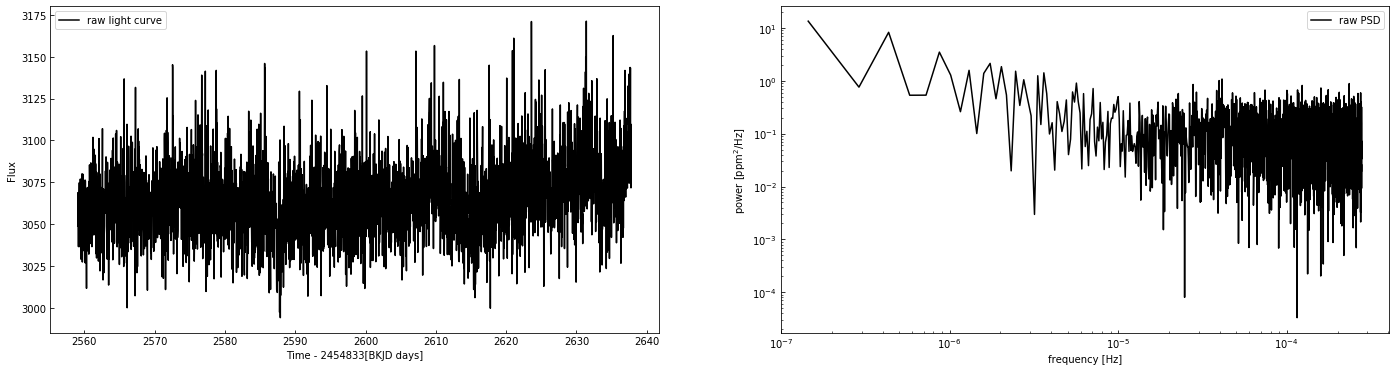

In [172]:
fig, ax = plt.subplots(1,2, figsize=(24,6))
plot_lc_PSD(lc_raw.time, lc_raw.flux, ax[0], ax[1], l="raw", f=k2_freq, color='k', alpha=1.0)

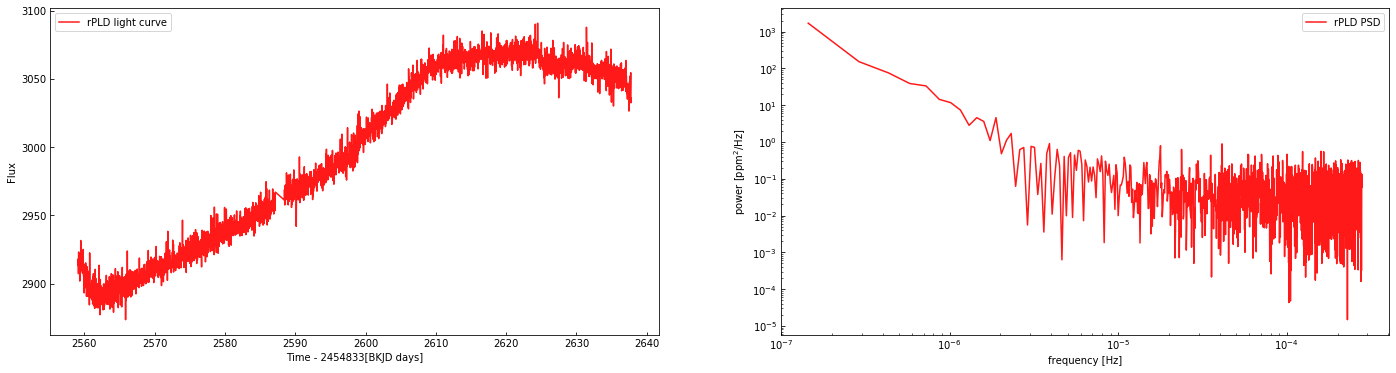

In [173]:
fig, ax = plt.subplots(1,2, figsize=(24,6))
sortingr = np.array(rpld_0.time[~rpld_0.mask]).argsort()
plot_lc_PSD(rpld_0.time[~rpld_mask_0], rpld_0.flux[~rpld_mask_0], ax[0], ax[1], l="rPLD", f=k2_freq,  color='r', alpha=0.9)

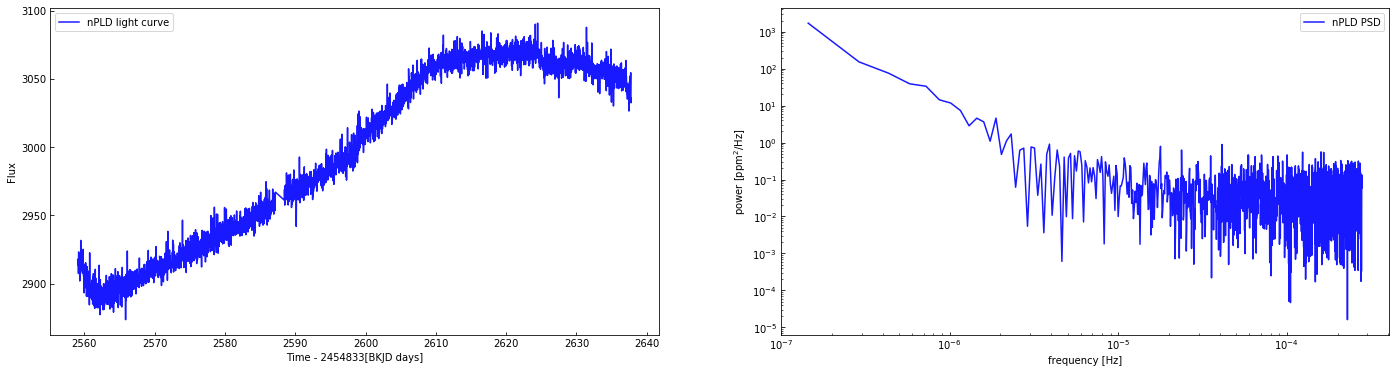

In [174]:
fig, ax = plt.subplots(1,2, figsize=(24,6))
plot_lc_PSD(npld_0.time[~npld_mask_0], npld_0.flux[~npld_mask_0], ax[0], ax[1], l="nPLD", f=k2_freq,  color='b', alpha=0.9)

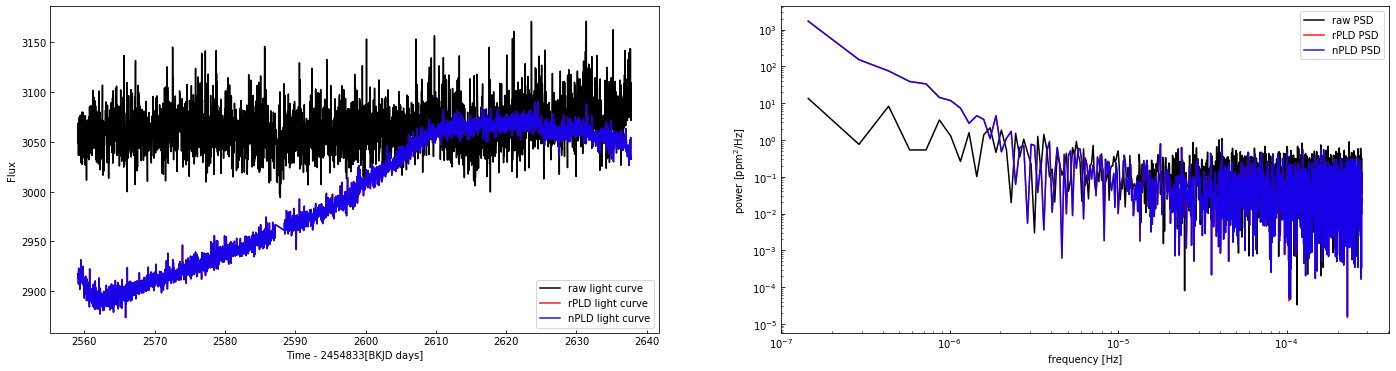

In [175]:
fig, ax = plt.subplots(1,2, figsize=(24,6))
plot_lc_PSD(lc_raw.time, lc_raw.flux, ax[0], ax[1], l="raw", f=k2_freq, color='k', alpha=1.0)
plot_lc_PSD(rpld_0.time[~rpld_mask_0], rpld_0.flux[~rpld_mask_0], ax[0], ax[1], l="rPLD", f=k2_freq,  color='r', alpha=0.9)
plot_lc_PSD(npld_0.time[~npld_mask_0], npld_0.flux[~npld_mask_0], ax[0], ax[1], l="nPLD", f=k2_freq,  color='b', alpha=0.9)

There is no clear distinction between rPLD and nPLD results. So, I'll stick to using just the nPLD corrector.

---

### Trying a 14th magnitude object

Well, EVEREST 2.0 claims to correct up to 14th magnitude. We know the Ed Shaya galaxies should look flat, so let's see if it works (without the the CBV corrections).

In [155]:
epics_mag14 = np.array(shaya['EPIC ID'][shaya.magnitude < 14])
shaya[shaya.magnitude < 14]

,EPIC ID,RA (J2000) [deg],Dec (J2000) [deg],magnitude,Investigation IDs,CHANNEL,IMAGE,MODULE,PIX_COL,PIX_ROW
131,220172951,16.070002,-1.074970,13.808,GO8070_LC,53,c8_lcs/220172951.png,16,151,425
206,220191057,18.239273,-0.345004,13.860,GO8070_LC,54,c8_lcs/220191057.png,16,82,1031
1006,220353364,12.710517,3.767033,13.672,GO8070_LC|GO8077_LC,64,c8_lcs/220353364.png,18,290,221
1137,220386281,9.956110,4.439195,13.959,GO8070_LC,81,c8_lcs/220386281.png,24,913,1003
1150,220391305,16.218117,4.539860,13.930,GO8070_LC|GO8077_LC|GO8042_LC,44,c8_lcs/220391305.png,13,639,611
1171,220397802,17.319431,4.672746,13.976,GO8070_LC|GO8077_LC|GO8042_LC,43,c8_lcs/220397802.png,13,698,130
1385,220451664,11.441187,5.715616,13.752,GO8070_LC|GO8077_LC|GO8042_LC,68,c8_lcs/220451664.png,19,774,333
1570,220497006,18.206879,6.698932,13.479,GO8070_LC|GO8077_LC|GO8042_LC,22,c8_lcs/220497006.png,8,1025,616
2249,220643631,16.078268,10.023949,13.417,GO8070_LC|GO8077_LC|GO8042_LC,27,c8_lcs/220643631.png,9,848,24


In [62]:
%%time
npld_mag14 = everest.detrender.nPLD(epics_mag14[0], season=8)

/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


CPU times: user 46min 27s, sys: 14min 5s, total: 1h 32s
Wall time: 23min 37s


/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


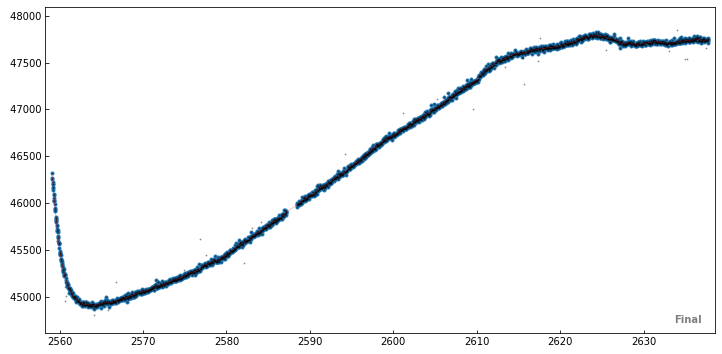

In [176]:
cmask = (np.isin(np.arange(3852+1), np.concatenate([npld_mag14.nanmask, npld_mag14.badmask, npld_mag14.mask])))

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(npld_mag14.time[~cmask], npld_mag14.flux[~cmask], '.')
npld_mag14.plot_final(ax)

Got the masking cadences figured out, but this doesn't look flat like we want it to!

Let's do the PSD.

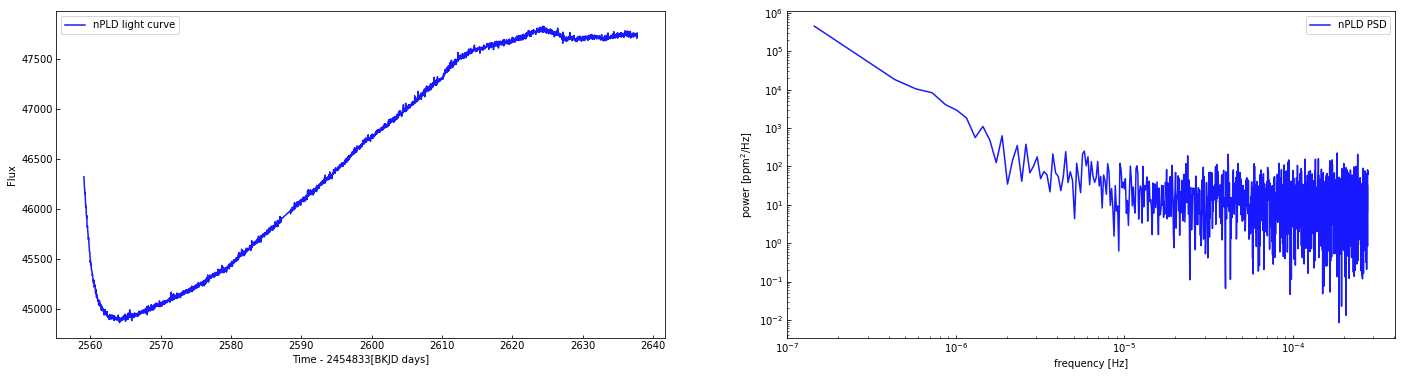

In [178]:
fig, ax = plt.subplots(1,2, figsize=(24,6))
plot_lc_PSD(npld_mag14.time[~cmask], npld_mag14.flux[~cmask], ax[0], ax[1], l="nPLD", f=k2_freq,  color='b', alpha=0.9)

# remove first few days and fit/remove a line

There is some longer timescale trend/polynomial trend added into the light curve. It doesn't look flat like we hoped.